In [26]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pathlib import Path
import os
import sys

# Configuração para visualizações inline no Jupyter
%matplotlib inline

# Configuração de estilo do seaborn
sns.set(style="whitegrid")

In [32]:
# Definição das funções de detecção de diretório e configuração de caminhos

def detect_base_dir(target_folder_name="economic-analysis-with-python"):
    """
    Detecta automaticamente o caminho base da aplicação percorrendo o diretório pai até encontrar a pasta alvo.

    Parâmetros:
        target_folder_name (str): O nome da pasta alvo que representa o caminho base da aplicação.

    Retorna:
        Path: O caminho para a pasta alvo.

    Se a pasta alvo não for encontrada, o script será encerrado com uma mensagem de erro.
    """
    try:
        # Tenta usar __file__, útil para scripts Python
        current_dir = Path(__file__).resolve().parent
    except NameError:
        # Fallback para Jupyter Notebook usando o diretório de trabalho atual
        current_dir = Path(os.getcwd()).resolve()

    while True:
        if current_dir.name == target_folder_name:
            return current_dir
        if current_dir.parent == current_dir:
            # Chegou ao diretório raiz sem encontrar a pasta alvo
            break
        current_dir = current_dir.parent

    print(f"Pasta base '{target_folder_name}' não encontrada. Verifique a estrutura de diretórios.")
    sys.exit(1)


def config_paths(base_dir):
    """
    Configura os caminhos para data_directory e output_dir relativamente ao caminho base.

    Parâmetros:
        base_dir (Path): O caminho base da aplicação.

    Retorna:
        tuple: Uma tupla contendo:
            - data_directory (Path): Caminho para o diretório de dados.
            - output_dir (Path): Caminho para o diretório de saída onde os resultados serão salvos.
    """
    # Definindo os caminhos relativos com base no diretório base
    data_directory = base_dir / "data"
    output_dir = base_dir / "src" / "results" / "inflation_analysis"

    return data_directory, output_dir


# Detectar o diretório base
base_dir = detect_base_dir()

# Configurar os caminhos relativos
data_directory, output_dir = config_paths(base_dir)

# Definição do caminho do arquivo de dados
file_path = data_directory / "inflation_data.txt"

# Definição do caminho do diretório de saída
# Verificar se o diretório de saída existe; se não, criar
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)
    print(f"Diretório criado: {output_dir}")
else:
    print(f"Diretório já existe: {output_dir}")


Diretório já existe: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis


In [33]:
# Detectar o diretório base
base_dir = detect_base_dir()

# Configurar os caminhos relativos
data_directory, output_dir = config_paths(base_dir)

# Definição do caminho do arquivo de dados
file_path = data_directory / "inflation_data.txt"

# Definição do caminho do diretório de saída
# Verificar se o diretório de saída existe; se não, criar
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)
    print(f"Diretório criado: {output_dir}")
else:
    print(f"Diretório já existe: {output_dir}")

Diretório já existe: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis


In [34]:
# Leitura dos dados
data = pd.read_csv(
    file_path,
    sep='\t',
    decimal=',',
    na_values=['---'],
    encoding='utf-8'
)

# Exibição das primeiras linhas do dataframe
print("Primeiras linhas dos dados importados:")
print(data.head())

Primeiras linhas dos dados importados:
   Ano/Mês   Jan   Fev   Mar   Abr   Mai   Jun   Jul   Ago   Set   Out   Nov  \
0     2024  0.97  0.80  0.83  0.89  0.83  0.79  0.91  0.87  0.84  0.93  0.54   
1     2023  1.12  0.92  1.17  0.92  1.12  1.07  1.07  1.14  0.97  1.00  0.92   
2     2022  0.73  0.76  0.93  0.83  1.03  1.02  1.03  1.17  1.07  1.02  1.02   
3     2021  0.15  0.13  0.20  0.21  0.27  0.31  0.36  0.43  0.44  0.49  0.59   
4     2020  0.38  0.29  0.34  0.28  0.24  0.21  0.19  0.16  0.16  0.16  0.15   

    Dez  Acumulado  
0   NaN       9.58  
1  0.89      13.04  
2  1.12      12.39  
3  0.77       4.42  
4  0.16       2.76  


In [35]:
# Remoção da coluna 'Acumulado' e transformação para formato longo
data_long = data.melt(
    id_vars=['Ano/Mês'],
    var_name='Mês',
    value_name='Inflação'
)

# Remoção das entradas 'Acumulado'
data_long = data_long[data_long['Mês'] != 'Acumulado']

# Mapeamento dos nomes dos meses em português para números
mapeamento_meses = {
    'Jan': 1, 'Fev': 2, 'Mar': 3, 'Abr': 4, 'Mai': 5, 'Jun': 6,
    'Jul': 7, 'Ago': 8, 'Set': 9, 'Out': 10, 'Nov': 11, 'Dez': 12
}
data_long['Mês'] = data_long['Mês'].map(mapeamento_meses)

# Renomeação da coluna 'Ano/Mês' para 'Ano'
data_long.rename(columns={'Ano/Mês': 'Ano'}, inplace=True)

# Criação da coluna 'Data'
data_long['Data'] = pd.to_datetime({
    'year': data_long['Ano'],
    'month': data_long['Mês'],
    'day': 1
}, errors='coerce')

# Conversão da coluna 'Inflação' para numérico
data_long['Inflação'] = pd.to_numeric(data_long['Inflação'], errors='coerce')

# Exibição das primeiras linhas do dataframe transformado
print("\nPrimeiras linhas dos dados transformados:")
print(data_long.head())

# Definição da série temporal
serie_temporal = data_long.set_index('Data')['Inflação'].sort_index()

# Garantir que o índice está no formato datetime
serie_temporal.index = pd.to_datetime(serie_temporal.index)

# Criar um índice de datas mensais abrangendo todos os períodos dos dados
date_range = pd.date_range(start=serie_temporal.index.min(), end=serie_temporal.index.max(),
                           freq='MS')  # 'MS' = Month Start

# Reindexar a série temporal para incluir todos os meses
serie_temporal = serie_temporal.reindex(date_range)

# Renomear o índice para 'Data' (opcional)
serie_temporal.index.name = 'Data'

# Verificação inicial de valores ausentes
num_missing = serie_temporal.isnull().sum()
print(f"\nNúmero de valores ausentes na série temporal: {num_missing}")

if num_missing > 0:
    print("Datas com valores ausentes:")
    missing_dates = serie_temporal[serie_temporal.isnull()].index
    print(missing_dates)

    # Tratamento dos valores ausentes usando interpolação linear
    serie_temporal_interpolada = serie_temporal.interpolate(method='linear')

    # Preenchimento forward para quaisquer valores restantes no início
    serie_temporal_interpolada = serie_temporal_interpolada.ffill()

    # Preenchimento backward para quaisquer valores restantes no final
    serie_temporal_interpolada = serie_temporal_interpolada.bfill()

    # Verificação após tratamento
    num_missing_after = serie_temporal_interpolada.isnull().sum()
    print(f"\nNúmero de valores ausentes após tratamento: {num_missing_after}")

    if num_missing_after == 0:
        print("Todos os valores ausentes foram tratados com sucesso.")
    else:
        print("Ainda existem valores ausentes na série temporal.")
else:
    # Se não houver valores ausentes
    serie_temporal_interpolada = serie_temporal.copy()
    print("Nenhum valor ausente encontrado na série temporal.")


Primeiras linhas dos dados transformados:
    Ano  Mês  Inflação       Data
0  2024    1      0.97 2024-01-01
1  2023    1      1.12 2023-01-01
2  2022    1      0.73 2022-01-01
3  2021    1      0.15 2021-01-01
4  2020    1      0.38 2020-01-01

Número de valores ausentes na série temporal: 1
Datas com valores ausentes:
DatetimeIndex(['2024-12-01'], dtype='datetime64[ns]', name='Data', freq='MS')

Número de valores ausentes após tratamento: 0
Todos os valores ausentes foram tratados com sucesso.


In [36]:
# Obter as estatísticas descritivas
estatisticas = data_long['Inflação'].describe()

# Definição do caminho completo para salvar as estatísticas
estatisticas_path = output_dir / 'txt/estatisticas_inflação.txt'

# Salvar as estatísticas em um arquivo .txt
with open(estatisticas_path, 'w', encoding='utf-8') as f:
    f.write("Estatísticas Descritivas da Inflação:\n\n")
    f.write(estatisticas.to_string())

print(f"Estatísticas descritivas salvas em: {estatisticas_path}")

Estatísticas descritivas salvas em: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\estatisticas_inflação.txt


Gráfico salvo em: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\inflacao_mensal_tempo.png


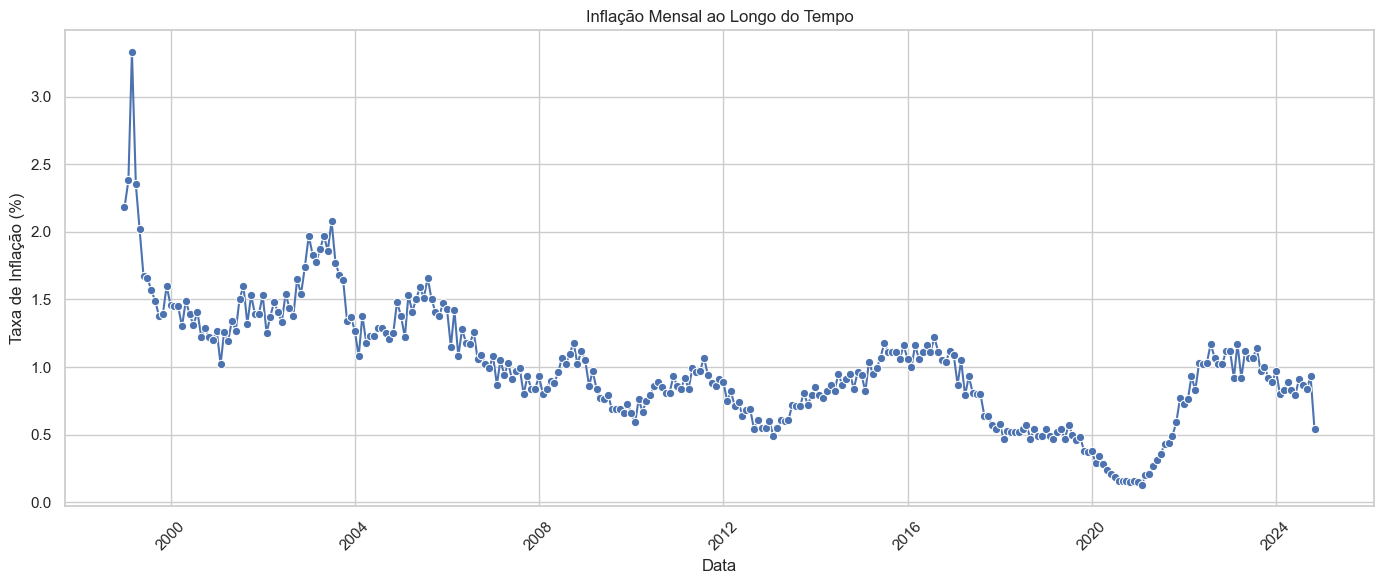

Dados transformados salvos em Excel: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\dados_transformados_inflação.xlsx
Dados transformados salvos em TXT: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\dados_transformados_inflação.txt
Dados transformados salvos em CSV: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\dados_transformados_inflação.csv


In [37]:
# Gráfico de linha da inflação mensal ao longo do tempo
plt.figure(figsize=(14, 6))
sns.lineplot(data=data_long, x='Data', y='Inflação', marker='o')
plt.title('Inflação Mensal ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Taxa de Inflação (%)')
plt.xticks(rotation=45)
plt.tight_layout()

# Definição do caminho completo para salvar o gráfico
grafico_path = output_dir / 'png/inflacao_mensal_tempo.png'

# Salvar o gráfico como PNG
plt.savefig(grafico_path, format='png')
print(f"Gráfico salvo em: {grafico_path}")

plt.show()

# Salvar os dados transformados em Excel (.xlsx)
dados_excel_path = output_dir / 'xlsx/dados_transformados_inflação.xlsx'
data_long.to_excel(dados_excel_path, index=False)
print(f"Dados transformados salvos em Excel: {dados_excel_path}")

# Salvar os dados transformados em Texto (.txt) com separador de tabulação
dados_txt_path = output_dir / 'txt/dados_transformados_inflação.txt'
data_long.to_csv(dados_txt_path, sep='\t', index=False)
print(f"Dados transformados salvos em TXT: {dados_txt_path}")

# Opcional: Salvar os dados transformados em CSV (.csv)
dados_csv_path = output_dir / 'csv/dados_transformados_inflação.csv'
data_long.to_csv(dados_csv_path, index=False)
print(f"Dados transformados salvos em CSV: {dados_csv_path}")

Inflação Anual Acumulada:
    Ano  Inflação
0  1999     23.02
1  2000     16.19
2  2001     16.08
3  2002     17.66
4  2003     21.16

Gráfico salvo em: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\png\inflacao_anual_acumulada.png


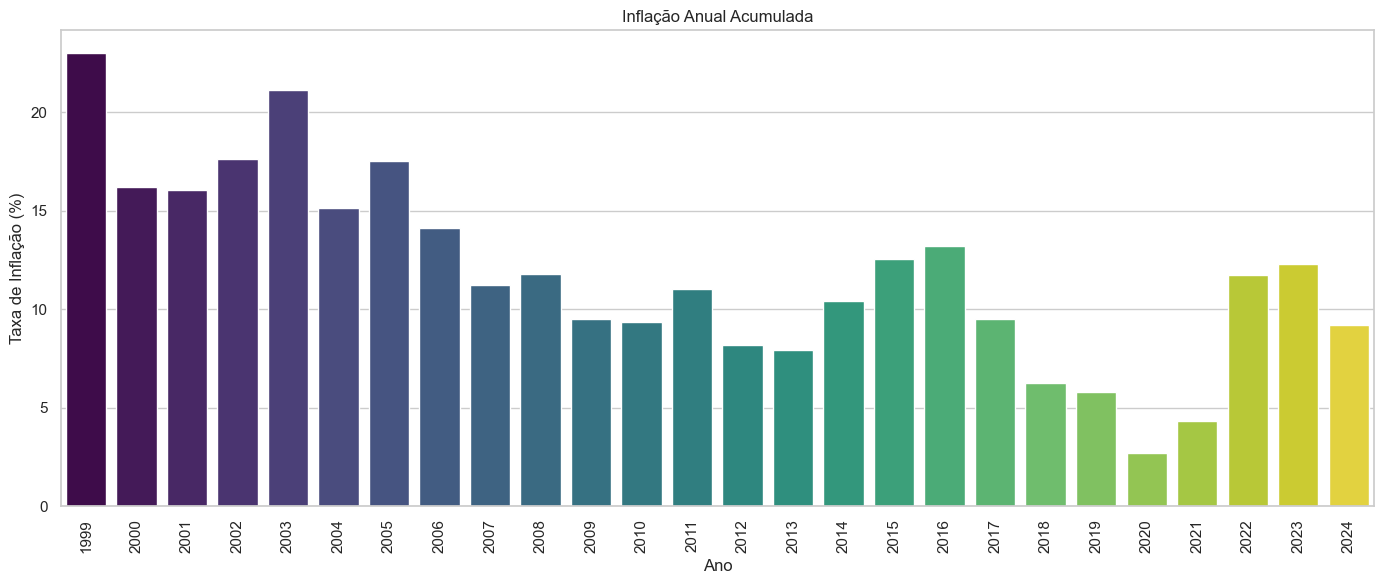


Dados de inflação anual acumulada salvos em Excel: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\xlsx\inflacao_anual_acumulada.xlsx

Dados de inflação anual acumulada salvos em TXT: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\txt\inflacao_anual_acumulada.txt

Dados de inflação anual acumulada salvos em CSV: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\csv\inflacao_anual_acumulada.csv


In [39]:
# Cálculo da inflação acumulada anual
inflacao_anual = data_long.groupby('Ano')['Inflação'].sum().reset_index()

# Exibir as primeiras linhas da inflação anual acumulada
print("Inflação Anual Acumulada:")
print(inflacao_anual.head())

# Gráfico de barras da inflação anual acumulada com 'hue' e sem legenda
plt.figure(figsize=(14, 6))
sns.barplot(
    data=inflacao_anual,
    x='Ano',
    y='Inflação',
    hue='Ano',  # Atribuição de 'Ano' ao hue para cores distintas
    palette='viridis',
    dodge=False  # Garante uma única barra por categoria
)
plt.title('Inflação Anual Acumulada')
plt.xlabel('Ano')
plt.ylabel('Taxa de Inflação (%)')
plt.xticks(rotation=90)
plt.legend([], [], frameon=False)  # Remove a legenda
plt.tight_layout()

# Definição do caminho completo para salvar o gráfico anual
grafico_anual_path = output_dir / 'png/inflacao_anual_acumulada.png'

# Salvar o gráfico como PNG
plt.savefig(grafico_anual_path, format='png')
print(f"\nGráfico salvo em: {grafico_anual_path}")

plt.show()

# Salvar os dados da inflação anual acumulada em Excel (.xlsx)
inflacao_anual_excel_path = output_dir / 'xlsx/inflacao_anual_acumulada.xlsx'
inflacao_anual.to_excel(inflacao_anual_excel_path, index=False)
print(f"\nDados de inflação anual acumulada salvos em Excel: {inflacao_anual_excel_path}")

# Salvar os dados da inflação anual acumulada em Texto (.txt) com separador de tabulação
inflacao_anual_txt_path = output_dir / 'txt/inflacao_anual_acumulada.txt'
inflacao_anual.to_csv(inflacao_anual_txt_path, sep='\t', index=False)
print(f"\nDados de inflação anual acumulada salvos em TXT: {inflacao_anual_txt_path}")

# Salvar os dados da inflação anual acumulada em CSV (.csv)
inflacao_anual_csv_path = output_dir / 'csv/inflacao_anual_acumulada.csv'
inflacao_anual.to_csv(inflacao_anual_csv_path, index=False)
print(f"\nDados de inflação anual acumulada salvos em CSV: {inflacao_anual_csv_path}")



Inflação Média Mensal:
   Mês  Inflação
0  Jan  1.037308
1  Fev  0.920000
2  Mar  1.073846
3  Abr  0.967692
4  Mai  1.017308

Gráfico salvo em: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\png\inflacao_media_mensal.png


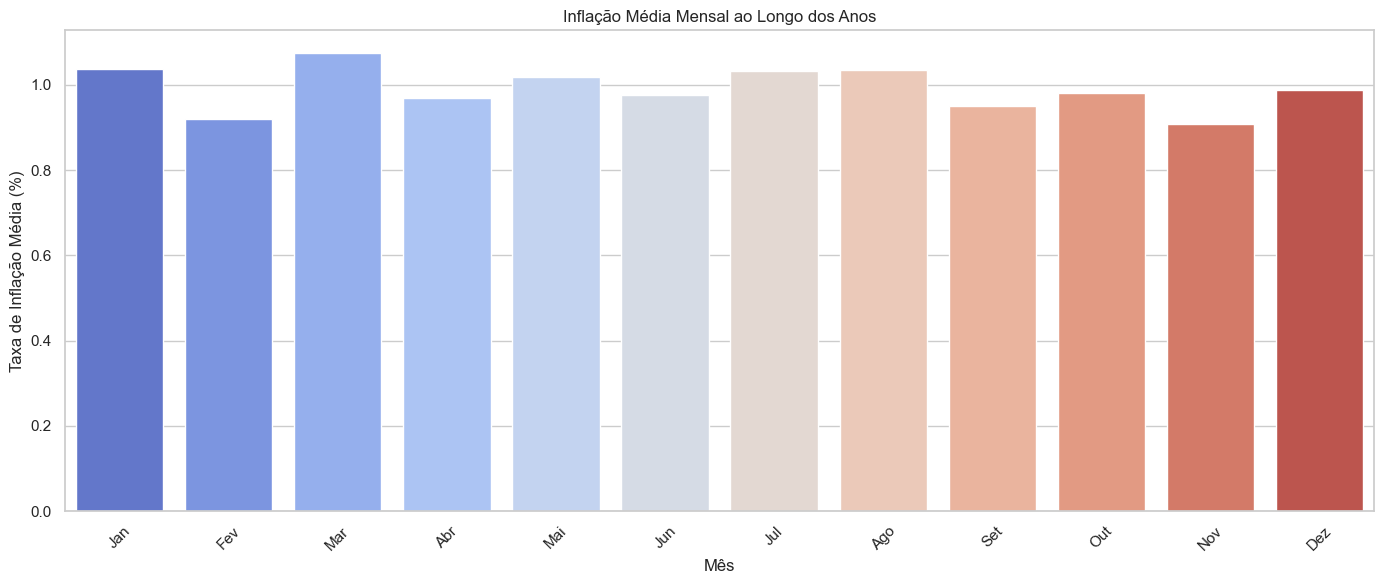


Dados de inflação média mensal salvos em Excel: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\xlsx\inflacao_media_mensal.xlsx

Dados de inflação média mensal salvos em TXT: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\txt\inflacao_media_mensal.txt

Dados de inflação média mensal salvos em CSV: C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\src\results\inflation_analysis\csv\inflacao_media_mensal.csv


In [40]:
# Cálculo da inflação média por mês
inflacao_media_mensal = data_long.groupby('Mês')['Inflação'].mean().reset_index()

# Mapeamento de volta dos números dos meses para nomes
mapeamento_meses_rev = {v: k for k, v in mapeamento_meses.items()}
inflacao_media_mensal['Mês'] = inflacao_media_mensal['Mês'].map(mapeamento_meses_rev)

# Definição da ordem dos meses para o gráfico
ordem_meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
               'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Ordenar os dados conforme a ordem dos meses
inflacao_media_mensal['Mês'] = pd.Categorical(inflacao_media_mensal['Mês'], categories=ordem_meses, ordered=True)
inflacao_media_mensal = inflacao_media_mensal.sort_values('Mês')

# Exibir as primeiras linhas da inflação média mensal
print("\nInflação Média Mensal:")
print(inflacao_media_mensal.head())

# Gráfico de barras da inflação média mensal com 'hue' e sem legenda
plt.figure(figsize=(14, 6))
sns.barplot(
    data=inflacao_media_mensal,
    x='Mês',
    y='Inflação',
    hue='Mês',  # Atribuição de 'Mês' ao hue para cores distintas
    palette='coolwarm',
    dodge=False  # Garante uma única barra por categoria
)
plt.title('Inflação Média Mensal ao Longo dos Anos')
plt.xlabel('Mês')
plt.ylabel('Taxa de Inflação Média (%)')
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)  # Remove a legenda
plt.tight_layout()

# Definição do caminho completo para salvar o gráfico mensal
grafico_mensal_path = output_dir / 'png' / 'inflacao_media_mensal.png'

# Salvar o gráfico como PNG
plt.savefig(grafico_mensal_path, format='png')
print(f"\nGráfico salvo em: {grafico_mensal_path}")

plt.show()

# Salvar os dados da inflação média mensal em Excel (.xlsx)
inflacao_media_mensal_excel_path = output_dir / 'xlsx' / 'inflacao_media_mensal.xlsx'
inflacao_media_mensal.to_excel(inflacao_media_mensal_excel_path, index=False)
print(f"\nDados de inflação média mensal salvos em Excel: {inflacao_media_mensal_excel_path}")

# Salvar os dados da inflação média mensal em Texto (.txt) com separador de tabulação
inflacao_media_mensal_txt_path = output_dir / 'txt' / 'inflacao_media_mensal.txt'
inflacao_media_mensal.to_csv(inflacao_media_mensal_txt_path, sep='\t', index=False)
print(f"\nDados de inflação média mensal salvos em TXT: {inflacao_media_mensal_txt_path}")

# Salvar os dados da inflação média mensal em CSV (.csv)
inflacao_media_mensal_csv_path = output_dir / 'csv' / 'inflacao_media_mensal.csv'
inflacao_media_mensal.to_csv(inflacao_media_mensal_csv_path, index=False)
print(f"\nDados de inflação média mensal salvos em CSV: {inflacao_media_mensal_csv_path}")

Primeiras linhas dos dados importados:
   Ano/Mês   Jan   Fev   Mar   Abr   Mai   Jun   Jul   Ago   Set   Out   Nov  \
0     2024  0.97  0.80  0.83  0.89  0.83  0.79  0.91  0.87  0.84  0.93  0.54   
1     2023  1.12  0.92  1.17  0.92  1.12  1.07  1.07  1.14  0.97  1.00  0.92   
2     2022  0.73  0.76  0.93  0.83  1.03  1.02  1.03  1.17  1.07  1.02  1.02   
3     2021  0.15  0.13  0.20  0.21  0.27  0.31  0.36  0.43  0.44  0.49  0.59   
4     2020  0.38  0.29  0.34  0.28  0.24  0.21  0.19  0.16  0.16  0.16  0.15   

    Dez  Acumulado  
0   NaN       9.58  
1  0.89      13.04  
2  1.12      12.39  
3  0.77       4.42  
4  0.16       2.76  

Primeiras linhas dos dados transformados:
    Ano  Mês  Inflação       Data
0  2024    1      0.97 2024-01-01
1  2023    1      1.12 2023-01-01
2  2022    1      0.73 2022-01-01
3  2021    1      0.15 2021-01-01
4  2020    1      0.38 2020-01-01

Número de valores ausentes na série temporal: 1
Datas com valores ausentes:
DatetimeIndex(['2024-12-01'], 

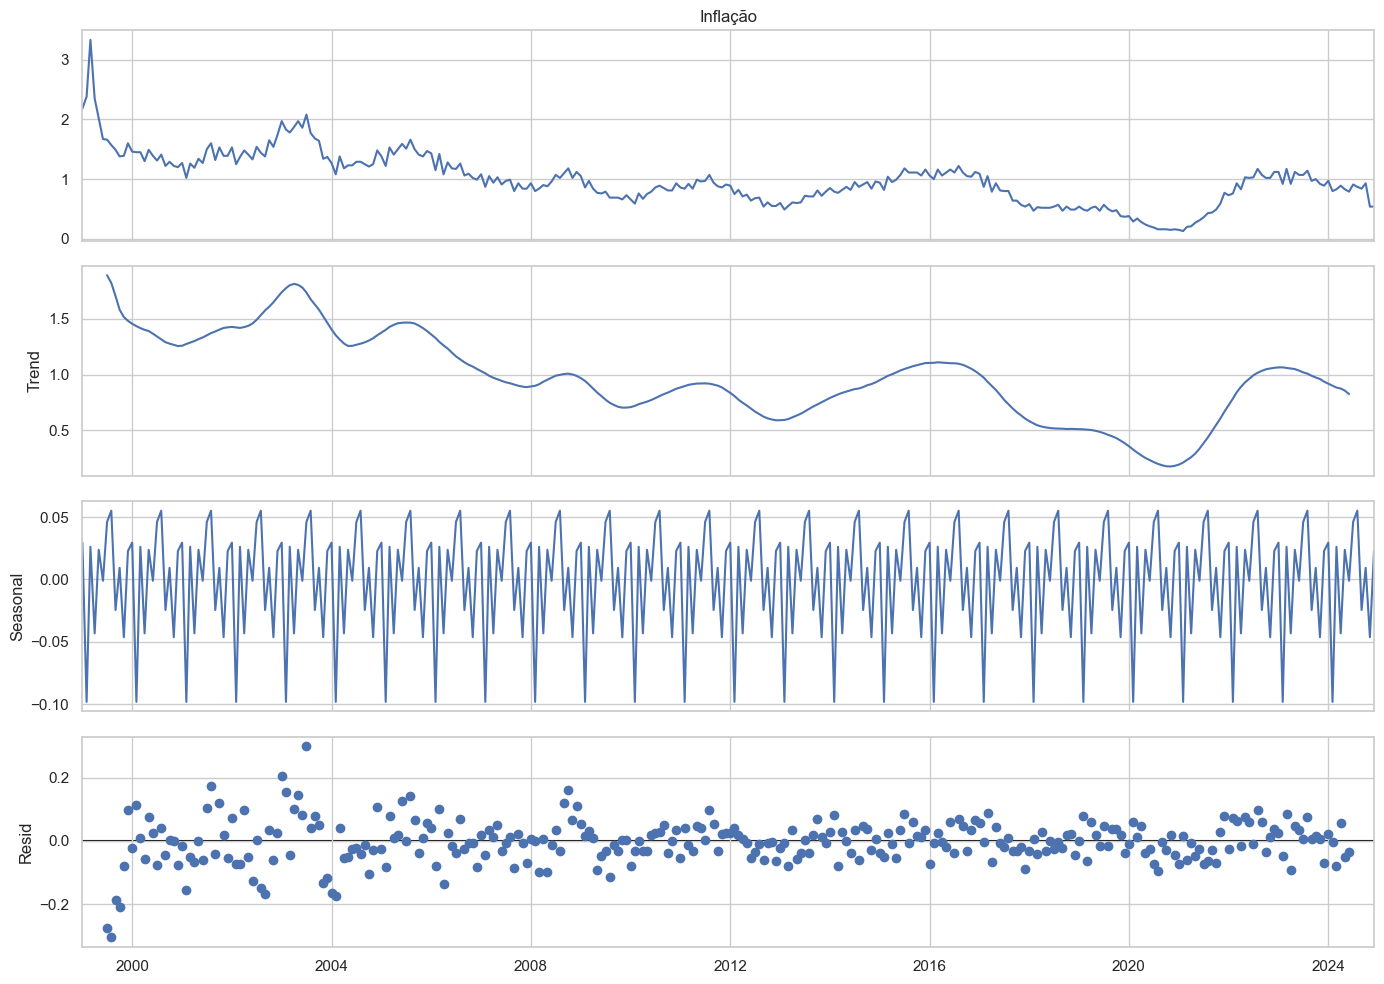

In [15]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Configuração para visualizações inline no Jupyter
%matplotlib inline

# Configuração de estilo do seaborn
sns.set(style="whitegrid")

# Definição do caminho do arquivo
file_path = r'C:\Users\Vinícius Andrade\Desktop\economic-analysis-with-python\data\inflation_data.txt'

# Leitura dos dados
data = pd.read_csv(
    file_path,
    sep='\t',
    decimal=',',
    na_values=['---'],
    encoding='utf-8'
)

# Exibição das primeiras linhas do dataframe
print("Primeiras linhas dos dados importados:")
print(data.head())

# Remoção da coluna 'Acumulado' e transformação para formato longo
data_long = data.melt(
    id_vars=['Ano/Mês'],
    var_name='Mês',
    value_name='Inflação'
)

# Remoção das entradas 'Acumulado'
data_long = data_long[data_long['Mês'] != 'Acumulado']

# Mapeamento dos nomes dos meses em português para números
mapeamento_meses = {
    'Jan': 1, 'Fev': 2, 'Mar': 3, 'Abr': 4, 'Mai': 5, 'Jun': 6,
    'Jul': 7, 'Ago': 8, 'Set': 9, 'Out': 10, 'Nov': 11, 'Dez': 12
}
data_long['Mês'] = data_long['Mês'].map(mapeamento_meses)

# Renomeação da coluna 'Ano/Mês' para 'Ano'
data_long.rename(columns={'Ano/Mês': 'Ano'}, inplace=True)

# Criação da coluna 'Data'
data_long['Data'] = pd.to_datetime({
    'year': data_long['Ano'],
    'month': data_long['Mês'],
    'day': 1
}, errors='coerce')

# Conversão da coluna 'Inflação' para numérico
data_long['Inflação'] = pd.to_numeric(data_long['Inflação'], errors='coerce')

# Exibição das primeiras linhas do dataframe transformado
print("\nPrimeiras linhas dos dados transformados:")
print(data_long.head())

# Definição da série temporal
serie_temporal = data_long.set_index('Data')['Inflação'].sort_index()

# Garantir que o índice está no formato datetime
serie_temporal.index = pd.to_datetime(serie_temporal.index)

# Criar um índice de datas mensais abrangendo todos os períodos dos dados
date_range = pd.date_range(start=serie_temporal.index.min(), end=serie_temporal.index.max(),
                           freq='MS')  # 'MS' = Month Start

# Reindexar a série temporal para incluir todos os meses
serie_temporal = serie_temporal.reindex(date_range)

# Renomear o índice para 'Data' (opcional)
serie_temporal.index.name = 'Data'

# Verificação inicial de valores ausentes
num_missing = serie_temporal.isnull().sum()
print(f"\nNúmero de valores ausentes na série temporal: {num_missing}")

if num_missing > 0:
    print("Datas com valores ausentes:")
    missing_dates = serie_temporal[serie_temporal.isnull()].index
    print(missing_dates)

    # Tratamento dos valores ausentes usando interpolação linear
    serie_temporal_interpolada = serie_temporal.interpolate(method='linear')

    # Preenchimento forward para quaisquer valores restantes no início
    serie_temporal_interpolada = serie_temporal_interpolada.ffill()

    # Preenchimento backward para quaisquer valores restantes no final
    serie_temporal_interpolada = serie_temporal_interpolada.bfill()

    # Verificação após tratamento
    num_missing_after = serie_temporal_interpolada.isnull().sum()
    print(f"\nNúmero de valores ausentes após tratamento: {num_missing_after}")

    if num_missing_after == 0:
        print("Todos os valores ausentes foram tratados com sucesso.")
    else:
        print("Ainda existem valores ausentes na série temporal.")
else:
    # Se não houver valores ausentes
    serie_temporal_interpolada = serie_temporal.copy()
    print("Nenhum valor ausente encontrado na série temporal.")

# Decomposição da série temporal
decomposicao = seasonal_decompose(serie_temporal_interpolada, model='additive', period=12)

# Plot da decomposição
fig = decomposicao.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()